In [1]:
# import packages
import glob
from pathlib import Path
import scipy.stats
import os
import numpy as np
from datetime import datetime
from datetime import timedelta
import pandas as pd
import calendar
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from pathos.threading import ThreadPool as Pool
from scipy.stats import gaussian_kde

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from f_sr_calculation import *

In [4]:
work_dir=Path("/scratch/fransjevanoors/global_sr")
# work_dir=Path("/mnt/u/LSM root zone/global_sr")

In [5]:
#colors
a = 255/255
b = 220/255
c = 201/255
d = 133/255
e = 85/255
f = 70/255
g = 46/255

c1 = (e,0,0)
c2 = (c,0,0)
c3 = (a,g,0)
c4 = (a,d,0)
c5 = (a,b,0)
c6 = (a,a,f)
c7 = (f,a,a)
c8 = (0,b,a)
c9 = (0,d,a)
c10 = (0,g,a)
c11 = (0,0,c)
c12 = (0,0,e)

colors=[c12,c11,c10,c9,c8,c7,c6,c5,c4,c3,c2,c1]
cm = ListedColormap(colors)

## 1. IWU VS IRRIGATED AREA FRACTION

In [11]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
ir = df.ir_mean
ir = ir[ir>0.01]
ir

br_0001850    0.010953
br_0002070    0.024101
br_0001612    0.057811
br_0002077    0.019123
fr_0000841    0.016864
                ...   
fr_0000347    0.010721
es_0000693    0.033156
fr_0000568    0.034826
za_0000075    0.016403
ca_0002259    0.011131
Name: ir_mean, Length: 1445, dtype: float64

In [12]:
# IWU IRRIGATION DATA
iwu = pd.read_csv(f'{work_dir}/output/irrigation/mean_irrigation_all_catchments.csv',index_col=0)
iwu = iwu['iwu_mean_mmday']
iwu = iwu[ir.index]

1.296068120226871 0.013360261930807894


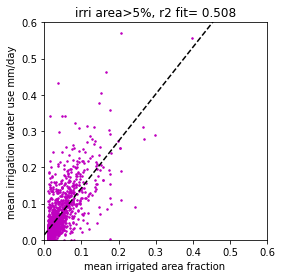

In [218]:
x = ir
y = iwu

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

xf = np.linspace(0,0.6,100)
yf = intercept + slope*xf

fig=plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(x,y,'mo',markersize=1.5)
ax.plot(xf,yf,'k--')
ax.set_xlabel('mean irrigated area fraction ')
ax.set_ylabel('mean irrigation water use mm/day')
ax.set_title(f'irri area>5%, r2 fit= {np.round(r_value**2,3)}')
ax.set_xlim(0,0.6)
ax.set_ylim(0,0.6)
print(slope,intercept)

## 2. WHERE IRRIGATION AND HOW MUCH?
Use GSIM irrigation data for catchments

In [46]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
ir = df.ir_mean
ira = df.ir_mean * df.area

In [47]:
# make list of catchments with > 5% irrigation
df = df[df.ir_mean>0.05]
c = df.index.values
np.savetxt(f'{work_dir}/output/irrigation/catchment_irri_area_5percent.txt',c,fmt='%s')

In [50]:
# IWU IRRIGATION DATA
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)

iwu = pd.read_csv(f'{work_dir}/output/irrigation/mean_irrigation_all_catchments.csv',index_col=0)
df2 = pd.concat([df,iwu],axis=1)
df2['iwu_mean_mmyear']=df2['iwu_mean_mmday']*365

Text(0.5, 0.98, 'Mean irrigation water use (mm/year)')

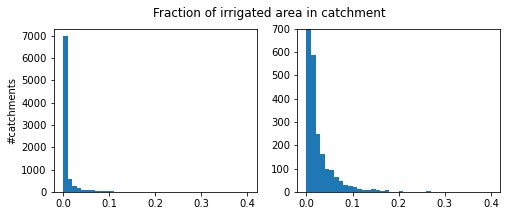

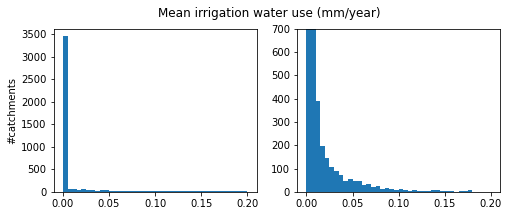

In [51]:
fig = plt.figure(figsize=(8,3))
bins = np.linspace(0,0.4,41)
ax = fig.add_subplot(121)
ax.hist(ir,bins=bins)
ax.set_ylabel(f'#catchments')

ax = fig.add_subplot(122)
ax.hist(ir,bins=bins)
# ax.set_ylabel(f'#catchments')
ax.set_ylim(0,700)

fig.suptitle('Fraction of irrigated area in catchment')

# histogram of IWU data
fig = plt.figure(figsize=(8,3))
bins = np.linspace(0,0.2,41)
ax = fig.add_subplot(121)
ax.hist(df2.iwu_mean_mmyear,bins=bins)
ax.set_ylabel(f'#catchments')

ax = fig.add_subplot(122)
ax.hist(ir,bins=bins)
# ax.set_ylabel(f'#catchments')
ax.set_ylim(0,700)

fig.suptitle('Mean irrigation water use (mm/year)')

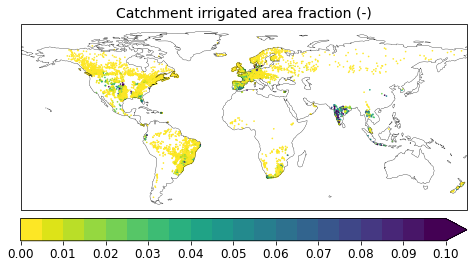

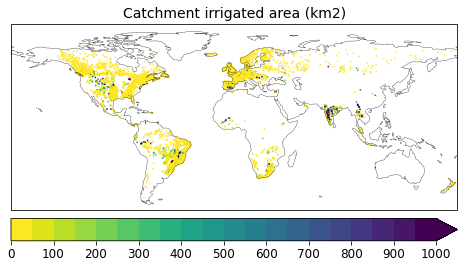

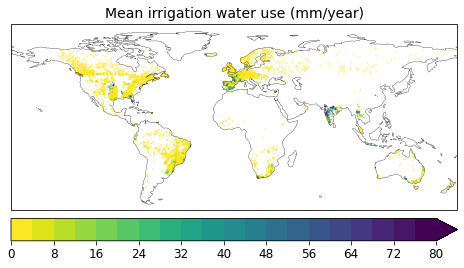

In [57]:
cmap = plt.cm.viridis_r  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,0.1,21)
bounds2 = np.linspace(0,0.1,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# IA
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(df.lon,df.lat,c=df.ir_mean,s=0.4,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='max', pad=0.02, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
# cbar.set_label('Irrigated area fraction (-)',size=12)
ax.set_title(f'Catchment irrigated area fraction (-)',size=14)
fig.savefig(f'{work_dir}/output/figures/irrigation/map_irri_area_fraction.jpg',dpi=200,bbox_inches='tight')


cmap = plt.cm.viridis_r  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,1000,21)
bounds2 = np.linspace(0,1000,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# IA * AREA
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(df.lon,df.lat,c=ira,s=0.4,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='max', pad=0.02, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
# cbar.set_label('Irrigated area (km2)',size=12)
ax.set_title(f'Catchment irrigated area (km2)',size=14)
fig.savefig(f'{work_dir}/output/figures/irrigation/map_irri_area.jpg',dpi=200,bbox_inches='tight')


cmap = plt.cm.viridis_r  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,80,21)
bounds2 = np.linspace(0,80,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(df2.lon,df2.lat,c=df2.iwu_mean_mmyear,s=0.1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.02, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
# cbar.set_label('Irrigated area (km2)',size=12)
ax.set_title(f'Mean irrigation water use (mm/year)',size=14)
fig.savefig(f'{work_dir}/output/figures/irrigation/map_mean_iwu.jpg',dpi=200,bbox_inches='tight')


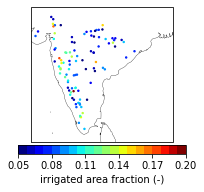

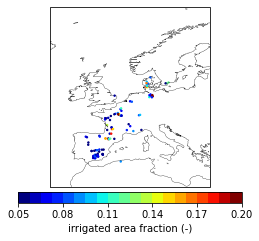

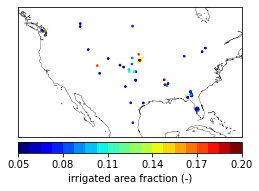

In [13]:
cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0.05,0.2,21)
bounds2 = np.linspace(0.05,0.2,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# INDIA
bounds3 = np.linspace(0.05,0.2,6)
fig = plt.figure(figsize=(3,3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(70,90)
ax.set_ylim(7,26)
s = ax.scatter(df.lon,df.lat,c=df.ir_mean,s=2,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='irrigated area fraction (-)',spacing='proportional', pad=0.02, norm=norm,ticks=bounds3)


# EUROPE
bounds3 = np.linspace(0.05,0.2,6)
fig = plt.figure(figsize=(4,4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-15,25)
ax.set_ylim(30,75)
s = ax.scatter(df.lon,df.lat,c=df.ir_mean,s=2,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='irrigated area fraction (-)',spacing='proportional', pad=0.02, norm=norm,ticks=bounds3)


# USA
bounds3 = np.linspace(0.05,0.2,6)
fig = plt.figure(figsize=(4,4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-130,-70)
ax.set_ylim(20,55)
s = ax.scatter(df.lon,df.lat,c=df.ir_mean,s=3,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='irrigated area fraction (-)',spacing='proportional', pad=0.02, norm=norm,ticks=bounds3)


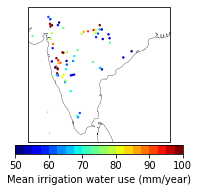

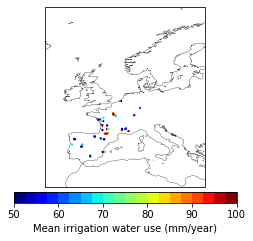

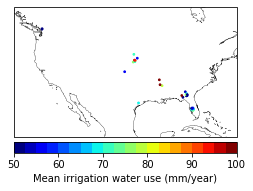

In [18]:
df2 = df2[df2.iwu_mean_mmyear>50]
cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(50,100,21)
bounds2 = np.linspace(50,100,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# INDIA
bounds3 = np.linspace(50,100,6)
fig = plt.figure(figsize=(3,3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(70,90)
ax.set_ylim(7,26)
s = ax.scatter(df2.lon,df2.lat,c=df2.iwu_mean_mmyear,s=2,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Mean irrigation water use (mm/year)',spacing='proportional', pad=0.02, norm=norm,ticks=bounds3)


# EUROPE
# bounds3 = np.linspace(0.05,0.2,6)
fig = plt.figure(figsize=(4,4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-15,25)
ax.set_ylim(30,75)
s = ax.scatter(df2.lon,df2.lat,c=df2.iwu_mean_mmyear,s=2,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Mean irrigation water use (mm/year)',spacing='proportional', pad=0.02, norm=norm,ticks=bounds3)


# USA
# bounds3 = np.linspace(0.05,0.2,6)
fig = plt.figure(figsize=(4,4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-130,-70)
ax.set_ylim(20,55)
s = ax.scatter(df2.lon,df2.lat,c=df2.iwu_mean_mmyear,s=3,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Mean irrigation water use (mm/year)',spacing='proportional', pad=0.02, norm=norm,ticks=bounds3)


## PLOT SD AND SE

In [133]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
ir = df.ir_mean
ir[ir>0.1]

in_0000142    0.173791
fr_0000889    0.128895
in_0000134    0.205674
in_0000064    0.115653
us_0002035    0.134372
                ...   
de_0000056    0.243320
de_0000251    0.206805
in_0000274    0.116337
us_0005144    0.204863
in_0000251    0.138393
Name: ir_mean, Length: 88, dtype: float64

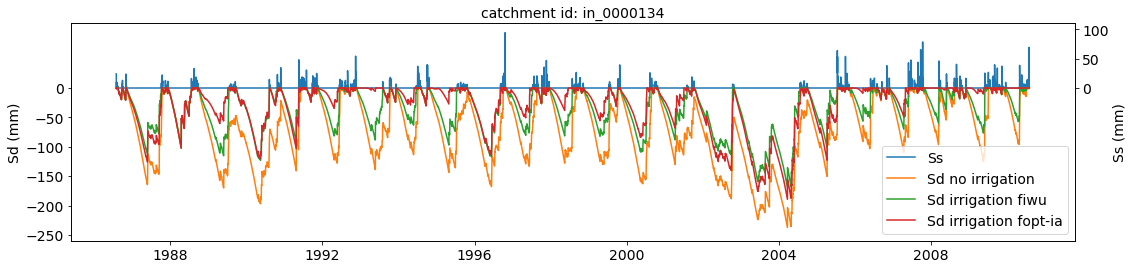

In [43]:
catch_id = 'in_0000134'
sd_f0 = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sd/{catch_id}.csv',index_col=0)
sd_fiwu = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu/sd/{catch_id}_fiwu.csv',index_col=0)
sd_fopt = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f1.85ia/sd/{catch_id}_f1.85ia.csv',index_col=0)
sd_f0.index = pd.to_datetime(sd_f0.index)
sd_fiwu.index = pd.to_datetime(sd_fiwu.index)
sd_fopt.index = pd.to_datetime(sd_fopt.index)

# se_f0 = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/se/{catch_id}.csv',index_col=0)
se_fiwu = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu/se/{catch_id}_fiwu.csv',index_col=0)
# se_f0.index = pd.to_datetime(sd_f0.index)
se_fiwu.index = pd.to_datetime(se_fiwu.index)

fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(111)
ax2 = ax.twinx()

ax.plot(sd_fiwu.index,sd_fiwu.se2, label='Ss')
ax.plot(sd_f0.index,sd_f0.Sd, label='Sd no irrigation')
ax.plot(sd_fiwu.index,sd_fiwu.sd2, label='Sd irrigation fiwu')
ax.plot(sd_fopt.index,sd_fopt.sd2, label='Sd irrigation fopt-ia')
ax.set_yticks([0,-50,-100,-150,-200,-250])
ax2.set_yticks([0,50,100])
ax.set_ylim(-260,110)
ax2.set_ylim(-260,110)
ax.set_ylabel('Sd (mm)', size=14)
ax2.set_ylabel('Ss (mm)', size=14)
ax.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)

ax.legend(fontsize=14)
ax.set_title(f'catchment id: {catch_id}',size=14)
fig.savefig(f'{work_dir}/output/figures/irrigation/sd_ss_timeseries.jpg',dpi=200,bbox_inches='tight')


## 3. OPTIMIZE F

In [7]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
ir = df.ir_mean

In [8]:
el_id_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu/se/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-9] # remove .year extension
    el_id_list.append(f)
print(len(el_id_list))

4603


In [9]:
# get fiwu values for catchments with ia>0, se only written for ia>0, sd for all catchments
f = 'iwu'
fm = []
for catch_id in el_id_list:
    if os.path.exists(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu/se/{catch_id}_f{f}.csv'):
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu/se/{catch_id}_f{f}.csv',index_col=0)
        fmean = d['f'].mean()
        fm.append(fmean)
print(len(fm))

4603


Text(0.5, 1.0, 'mean:0.026, median:0.001, std:0.063, iqr:0.017')

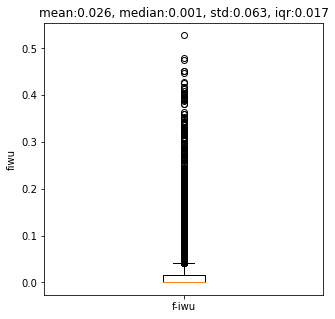

In [10]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.boxplot(fm)
ax.set_xticklabels(['f-iwu'])
ax.set_ylabel('fiwu')
fmmean = np.round(np.mean(fm),3)
fmmedian = np.round(np.median(fm),3)
fmstd = np.round(np.std(fm),3)
fmiqr = np.round((np.quantile(fm,0.75) - np.quantile(fm,0.25)),3)
ax.set_title(f'mean:{fmmean}, median:{fmmedian}, std:{fmstd}, iqr:{fmiqr}')

In [11]:
d=pd.DataFrame(index=el_id_list, columns=['fiwu'])
d['fiwu']=fm
d['ia'] = ir
d['fopt'] = d['fiwu']/d['ia']
d.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f_optimization.csv')

In [12]:
d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f_optimization.csv', index_col=0)
d

,fiwu,ia,fopt
de_0000401,0.000000,0.000181,0.000000
es_0000199,0.038658,0.009154,4.223202
br_0000380,0.000447,0.000772,0.579474
es_0000468,0.016736,0.004352,3.845690
at_0000087,0.000000,0.000011,0.000000
...,...,...,...
br_0000469,0.000000,0.000201,0.000000
at_0000174,0.000211,0.000143,1.479125
de_0000123,0.007957,0.025498,0.312084
ca_0004063,0.000000,0.000993,0.000000


In [13]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [14]:
# MINIMIZE ABSOLUTE ERROR
f_min=0
f_max=4
nmax=10000
A=np.zeros((int(nmax),6))

for n in range(1,int(nmax+1)): 
    Rnum=np.random.rand(1)
    f = f_min+(f_max-f_min)*Rnum

    o = f*d['ia']
    er = o-d['fiwu']
    er_m = er.mean()
    er_std =er.std()
    er_med = er.median()
    er_iqr =er.quantile(0.75) - er.quantile(0.25)
    er_rmse = np.sqrt(np.mean((o-d['fiwu'])**2))
    
    A[n-1,:] = [f,er_m,er_std,er_med,er_iqr,er_rmse]
    
ind=find_nearest(A[:,1],0)
fopt_mean=np.round(A[ind,0],3)

ind=np.argmin(A[:,2])
fopt_std=np.round(A[ind,0],3)

ind=find_nearest(A[:,3],0)
fopt_median=np.round(A[ind,0],3)

ind=np.argmin(A[:,4])
fopt_iqr=np.round(A[ind,0],3)

ind=np.argmin(A[:,5])
fopt_rmse=np.round(A[ind,0],3)

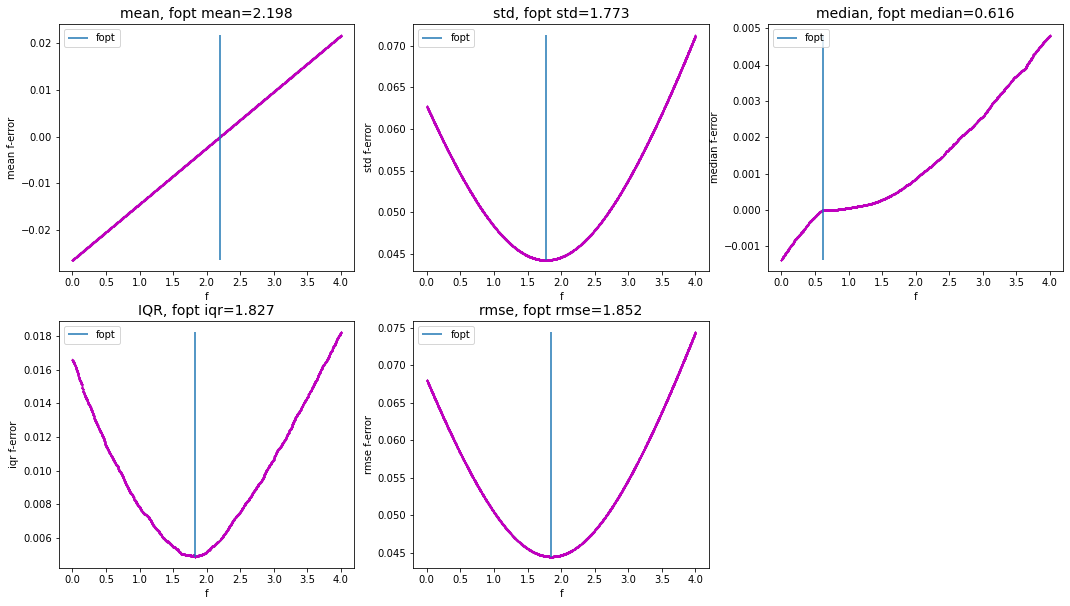

In [15]:
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(231)
ax.plot(A[:,0], A[:,1],'mo',markersize=0.5)
ax.vlines(fopt_mean,A[:,1].min(),A[:,1].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('mean f-error')
ax.set_title(f'mean, fopt mean={fopt_mean}',size=14)
ax.legend()

ax = fig.add_subplot(232)
ax.plot(A[:,0], A[:,2],'mo',markersize=0.5)
ax.vlines(fopt_std,A[:,2].min(),A[:,2].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('std f-error')
ax.set_title(f'std, fopt std={fopt_std}',size=14)
ax.legend()

ax = fig.add_subplot(233)
ax.plot(A[:,0], A[:,3],'mo',markersize=0.5)
ax.vlines(fopt_median,A[:,3].min(),A[:,3].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('median f-error')
ax.set_title(f'median, fopt median={fopt_median}',size=14)
ax.legend()

ax = fig.add_subplot(234)
ax.plot(A[:,0], A[:,4],'mo',markersize=0.5)
ax.vlines(fopt_iqr,A[:,4].min(),A[:,4].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('iqr f-error')
ax.set_title(f'IQR, fopt iqr={fopt_iqr}',size=14)
ax.legend()

ax = fig.add_subplot(235)
ax.plot(A[:,0], A[:,5],'mo',markersize=0.5)
ax.vlines(fopt_rmse,A[:,5].min(),A[:,5].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('rmse f-error')
ax.set_title(f'rmse, fopt rmse={fopt_rmse}',size=14)
ax.legend()

fig.savefig(f'{work_dir}/output/figures/irrigation/optimization/monte_carlo_absdiff.jpg',dpi=300,bbox_inches='tight')

,median,mean,std,iqr,rmse
2.198,0.001,0.000,0.046,0.006,0.045
0.616,-0.000,-0.019,0.053,0.011,0.056
1.773,0.001,-0.005,0.044,0.005,0.045
1.827,0.001,-0.004,0.044,0.005,0.044
1.852,0.001,-0.004,0.044,0.005,0.044


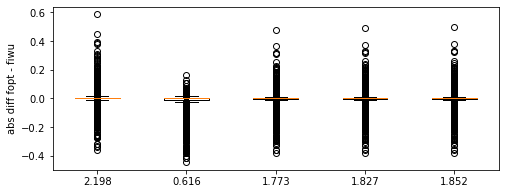

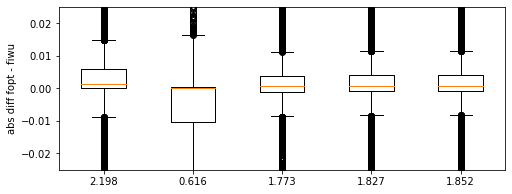

In [16]:
# boxplots
f_array=[fopt_mean,fopt_median,fopt_std,fopt_iqr,fopt_rmse]
f_array_str=[str(fopt_mean),str(fopt_median),str(fopt_std),str(fopt_iqr),str(fopt_rmse)]
df = pd.DataFrame(index=d.index, columns=f_array)

for f in f_array:
    o = f*d['ia']
    er = o-d['fiwu']
    df[f] = er
    
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.boxplot(df)
ax.set_xticklabels(f_array_str)
ax.set_ylabel('abs diff fopt - fiwu')

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.boxplot(df)
ax.set_xticklabels(f_array_str)
ax.set_ylabel('abs diff fopt - fiwu')
ax.set_ylim(-0.025,0.025)
fig.savefig(f'{work_dir}/output/figures/irrigation/optimization/monte_carlo_absdiff_boxplot.jpg',dpi=300,bbox_inches='tight')

e = pd.DataFrame(index=df.columns)
e['median']=np.round(df.median(),3)
e['mean']=np.round(df.mean(),3)
e['std']=np.round(df.std(),3)
e['iqr'] = np.round((df.quantile(0.75) - df.quantile(0.25)),3)
e['rmse'] = np.round(np.sqrt(np.mean((df**2))),3)
e.index = [f_array_str]

e

In [17]:
# MINIMIZE RELATIVE ERROR
f_min=0
f_max=4
nmax=10000
A=np.zeros((int(nmax),6))

for n in range(1,int(nmax+1)): 
    Rnum=np.random.rand(1)
    f = f_min+(f_max-f_min)*Rnum
    o = f*d['ia']
    er = (o-d['fiwu'])/d['fiwu']
    er.replace([np.inf, -np.inf], np.nan, inplace=True)
    er_m = er.mean()
    er_std =er.std()
    er_med = er.median()
    er_iqr =er.quantile(0.75) - er.quantile(0.25)
    er_rmse = np.sqrt(np.mean(((o-d['fiwu'])/d['fiwu'])**2))
    
    A[n-1,:] = [f,er_m,er_std,er_med,er_iqr,er_rmse]
    
ind=find_nearest(A[:,1],0)
fopt_mean=np.round(A[ind,0],3)

ind=np.argmin(A[:,2])
fopt_std=np.round(A[ind,0],3)

ind=find_nearest(A[:,3],0)
fopt_median=np.round(A[ind,0],3)

ind=np.argmin(A[:,4])
fopt_iqr=np.round(A[ind,0],3)

ind=np.argmin(A[:,5])
fopt_rmse=np.round(A[ind,0],3)

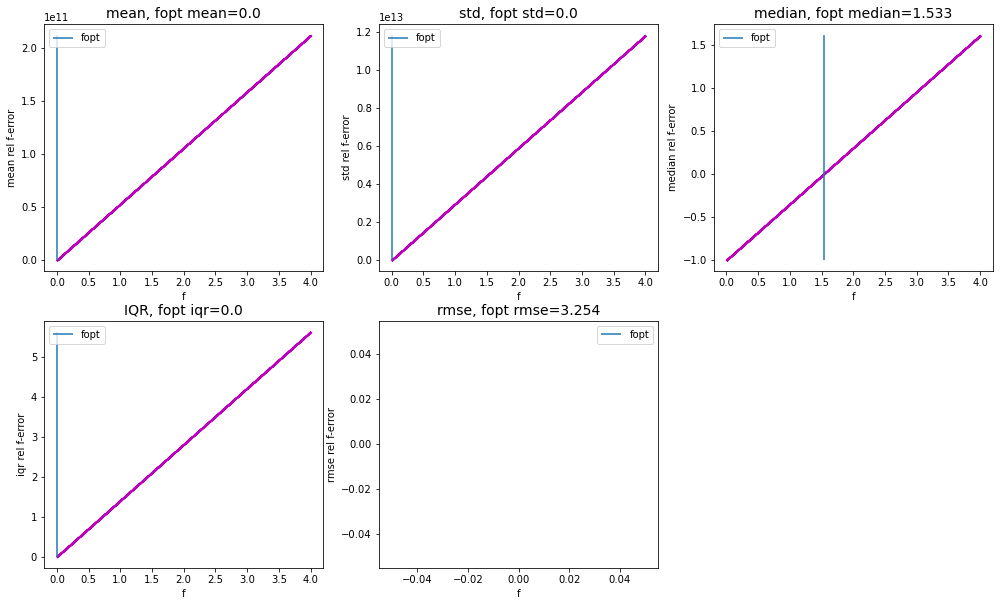

In [18]:
fig = plt.figure(figsize=(17,10))
ax = fig.add_subplot(231)
ax.plot(A[:,0], A[:,1],'mo',markersize=0.5)
ax.vlines(fopt_mean,A[:,1].min(),A[:,1].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('mean rel f-error')
ax.set_title(f'mean, fopt mean={fopt_mean}',size=14)
ax.legend()

ax = fig.add_subplot(232)
ax.plot(A[:,0], A[:,2],'mo',markersize=0.5)
ax.vlines(fopt_std,A[:,2].min(),A[:,2].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('std rel f-error')
ax.set_title(f'std, fopt std={fopt_std}',size=14)
ax.legend()

ax = fig.add_subplot(233)
ax.plot(A[:,0], A[:,3],'mo',markersize=0.5)
ax.vlines(fopt_median,A[:,3].min(),A[:,3].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('median rel f-error')
ax.set_title(f'median, fopt median={fopt_median}',size=14)
ax.legend()

ax = fig.add_subplot(234)
ax.plot(A[:,0], A[:,4],'mo',markersize=0.5)
ax.vlines(fopt_iqr,A[:,4].min(),A[:,4].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('iqr rel f-error')
ax.set_title(f'IQR, fopt iqr={fopt_iqr}',size=14)
ax.legend()

ax = fig.add_subplot(235)
ax.plot(A[:,0], A[:,5],'mo',markersize=0.5)
ax.vlines(fopt_rmse,A[:,5].min(),A[:,5].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('rmse rel f-error')
ax.set_title(f'rmse, fopt rmse={fopt_rmse}',size=14)
ax.legend()

,median,mean,std,iqr,rmse
0.0,-1.000,-1.000000e+00,0.000000e+00,0.000,1.000000e+00
1.533,-0.000,8.109659e+10,4.523270e+12,2.157,4.523270e+12
0.0,-1.000,-1.000000e+00,0.000000e+00,0.000,1.000000e+00
0.0,-1.000,-1.000000e+00,0.000000e+00,0.000,1.000000e+00
3.254,1.122,1.721385e+11,9.601254e+12,4.579,9.601254e+12


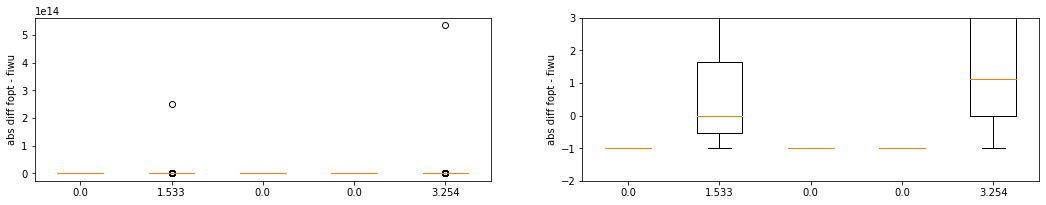

In [19]:
# boxplots
f_array=[fopt_mean,fopt_median,fopt_std,fopt_iqr,fopt_rmse]
f_array_str=[str(fopt_mean),str(fopt_median),str(fopt_std),str(fopt_iqr),str(fopt_rmse)]
df = pd.DataFrame(index=d.index, columns=f_array)

for f in f_array:
    o = f*d['ia']
    er = (o-d['fiwu'])/d['fiwu']
    er.replace([np.inf, -np.inf], np.nan, inplace=True)
    # er = er.dropna()
    df[f] = er
    
df = df.dropna()
    
fig = plt.figure(figsize=(18,3))
ax = fig.add_subplot(121)
ax.boxplot(df)
ax.set_xticklabels(f_array_str)
ax.set_ylabel('abs diff fopt - fiwu')

ax = fig.add_subplot(122)
ax.boxplot(df)
ax.set_xticklabels(f_array_str)
ax.set_ylabel('abs diff fopt - fiwu')
ax.set_ylim(-2,3)

e = pd.DataFrame(index=df.columns)
e['median']=np.round(df.median(),3)
e['mean']=np.round(df.mean(),3)
e['std']=np.round(df.std(),3)
e['iqr'] = np.round((df.quantile(0.75) - df.quantile(0.25)),3)
e['rmse'] = np.round(np.sqrt(np.mean((df**2))),3)
e.index = f_array_str

e

In [20]:
# MINIMIZE ABSOLUTE ERROR - without IA
f_min=0
f_max=4
nmax=5000
A=np.zeros((int(nmax),6))

for n in range(1,int(nmax+1)): 
    Rnum=np.random.rand(1)
    f = f_min+(f_max-f_min)*Rnum

    o = f
    er = o-d['fiwu']
    er_m = er.mean()
    er_std =er.std()
    er_med = er.median()
    er_iqr =er.quantile(0.75) - er.quantile(0.25)
    er_rmse = np.sqrt(np.mean((o-d['fiwu'])**2))
    
    A[n-1,:] = [f,er_m,er_std,er_med,er_iqr,er_rmse]
    
ind=find_nearest(A[:,1],0)
fopt_mean=np.round(A[ind,0],3)

ind=np.argmin(A[:,2])
fopt_std=np.round(A[ind,0],3)

ind=find_nearest(A[:,3],0)
fopt_median=np.round(A[ind,0],3)

ind=np.argmin(A[:,4])
fopt_iqr=np.round(A[ind,0],3)

ind=np.argmin(A[:,5])
fopt_rmse=np.round(A[ind,0],3)

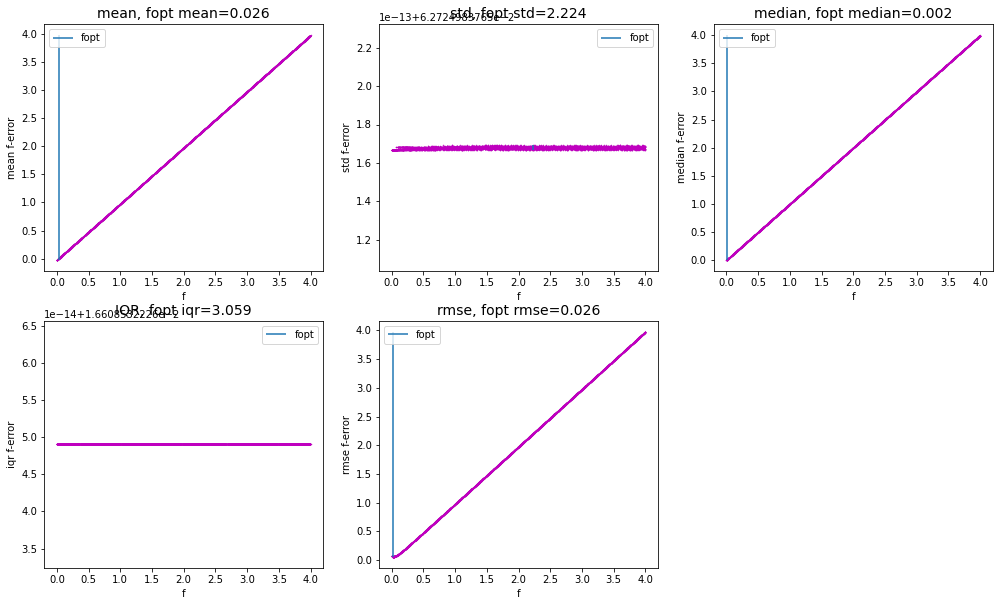

In [21]:
fig = plt.figure(figsize=(17,10))
ax = fig.add_subplot(231)
ax.plot(A[:,0], A[:,1],'mo',markersize=0.5)
ax.vlines(fopt_mean,A[:,1].min(),A[:,1].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('mean f-error')
ax.set_title(f'mean, fopt mean={fopt_mean}',size=14)
ax.legend()

ax = fig.add_subplot(232)
ax.plot(A[:,0], A[:,2],'mo',markersize=0.5)
ax.vlines(fopt_std,A[:,2].min(),A[:,2].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('std f-error')
ax.set_title(f'std, fopt std={fopt_std}',size=14)
ax.legend()

ax = fig.add_subplot(233)
ax.plot(A[:,0], A[:,3],'mo',markersize=0.5)
ax.vlines(fopt_median,A[:,3].min(),A[:,3].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('median f-error')
ax.set_title(f'median, fopt median={fopt_median}',size=14)
ax.legend()

ax = fig.add_subplot(234)
ax.plot(A[:,0], A[:,4],'mo',markersize=0.5)
ax.vlines(fopt_iqr,A[:,4].min(),A[:,4].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('iqr f-error')
ax.set_title(f'IQR, fopt iqr={fopt_iqr}',size=14)
ax.legend()

ax = fig.add_subplot(235)
ax.plot(A[:,0], A[:,5],'mo',markersize=0.5)
ax.vlines(fopt_rmse,A[:,5].min(),A[:,5].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('rmse f-error')
ax.set_title(f'rmse, fopt rmse={fopt_rmse}',size=14)
ax.legend()

,median,mean,std,iqr,rmse
f1.85ia - fiwu,0.001,-0.004,0.044,0.005,0.044


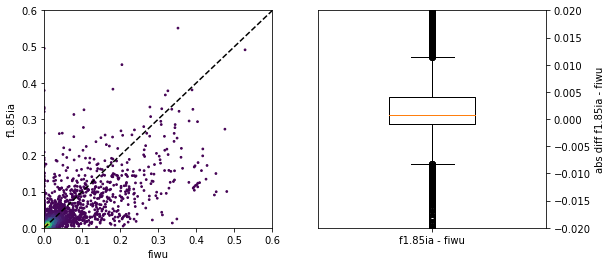

In [40]:
# fopt=1.85ia vs fiwu
d['f1.85ia'] = 1.85*d['ia']
d['dif'] = d['f1.85ia']-d['fiwu']
d['reldif'] = (d['f1.85ia']-d['fiwu'])/d['fiwu'] * 100

x = d['fiwu']
y = d['f1.85ia']

# calculate point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(121)
# ax.plot(d['fiwu'],d['f1.85ia'],'mo',markersize=1)
ax.scatter(x,y,c=z,s=3)
ax.plot([0,12],[0,12],'k--')
ax.set_xlabel('fiwu')
ax.set_ylabel('f1.85ia')
ax.set_xlim(0,0.6)
ax.set_ylim(0,0.6)

ax = fig.add_subplot(122)
d = d.dropna()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.boxplot(d['dif'])
ax.set_xticklabels(['f1.85ia - fiwu'])
ax.set_ylabel('abs diff f1.85ia - fiwu')
ax.set_ylim(-0.02,0.02)
ax.set_xlim(0.8,1.2)
fig.savefig(f'{work_dir}/output/figures/irrigation/fopt_vs_fiwu.jpg',bbox_inches='tight',dpi=300)

de = d['dif']

e = pd.DataFrame(index=['f1.85ia - fiwu'])
e['median']=np.round(de.median(),3)
e['mean']=np.round(de.mean(),3)
e['std']=np.round(de.std(),3)
e['iqr'] = np.round((de.quantile(0.75) - de.quantile(0.25)),3)
e['rmse'] = np.round(np.sqrt(np.mean((de**2))),3)
e

## 6. SR CALCULATION

In [9]:
# RUN SR CALCULATION 
catch_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel_area_wb.txt',dtype='str')[:]

# define directories
sd_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
out_dir = f'{work_dir}/output/sr_calculation/sd_catchments'

# define return periods
rp_array = [2,3,5,10,20,30,40,50,60,70,80]
f_array = ['1.8ia']
# f_array = ['iwu']
catch_id_list = catch_list
sd_dir_list = [sd_dir] * len(catch_id_list)
out_dir_list = [out_dir] * len(catch_id_list) 
rp_array_list = [rp_array] * len(catch_id_list) 
f_list = f_array * len(catch_id_list)

run_sr_calculation_parallel(catch_id_list,rp_array_list,sd_dir_list,out_dir_list,f_list) #run all catchments parallel on delftblue

In [27]:
# combine Sr output in dataframe - NO IRRI
c_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-4] # remove .year extension
    c_list.append(f)
# print(len(c_list))

sr_df = pd.DataFrame(index=c_list, columns=['2','3','5','10','20','30','40','50','60','70','80'])
for catch_id in c_list:
    if os.path.exists(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr/{catch_id}.csv'):
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr/{catch_id}.csv',index_col=0)
        sr_df.loc[catch_id] = d.iloc[0]
        
sr_df.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined.csv')

In [39]:
# combine Sr output in dataframe - f1.9ia
c_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f1.9ia/sr/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-11] # remove .year extension
    c_list.append(f)
# print(len(c_list))

sr_df = pd.DataFrame(index=c_list, columns=['2','3','5','10','20','30','40','50','60','70','80'])
for catch_id in c_list:
    if os.path.exists(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f1.9ia/sr/{catch_id}_f1.9ia.csv'):
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f1.9ia/sr/{catch_id}_f1.9ia.csv',index_col=0)
        sr_df.loc[catch_id] = d.iloc[0]
        
sr_df.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f1.9ia/sr_irri_f1.9ia_combined.csv')

In [10]:
# combine Sr output in dataframe - f1.8ia
c_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f1.8ia/sr/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-11] # remove .year extension
    c_list.append(f)
# print(len(c_list))

sr_df = pd.DataFrame(index=c_list, columns=['2','3','5','10','20','30','40','50','60','70','80'])
for catch_id in c_list:
    if os.path.exists(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f1.8ia/sr/{catch_id}_f1.8ia.csv'):
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f1.8ia/sr/{catch_id}_f1.8ia.csv',index_col=0)
        sr_df.loc[catch_id] = d.iloc[0]
        
sr_df.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f1.9ia/sr_irri_f1.8ia_combined.csv')

In [10]:
# combine Sr output in dataframe - f1.85ia
c_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f1.85ia/sr/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-12] # remove .year extension
    c_list.append(f)
# print(len(c_list))

sr_df = pd.DataFrame(index=c_list, columns=['2','3','5','10','20','30','40','50','60','70','80'])
for catch_id in c_list:
    if os.path.exists(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f1.85ia/sr/{catch_id}_f1.85ia.csv'):
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f1.85ia/sr/{catch_id}_f1.85ia.csv',index_col=0)
        sr_df.loc[catch_id] = d.iloc[0]
        
sr_df.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f1.85ia/sr_irri_f1.85ia_combined.csv')

In [20]:
# combine Sr output in dataframe - fiwu
c_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu/sr/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-9] # remove .year extension
    c_list.append(f)
print(len(c_list))

sr_df = pd.DataFrame(index=c_list, columns=['2','3','5','10','20','30','40','50','60','70','80'])
for catch_id in c_list:
    if os.path.exists(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu/sr/{catch_id}_fiwu.csv'):
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu/sr/{catch_id}_fiwu.csv',index_col=0)
        sr_df.loc[catch_id] = d.iloc[0]
        
sr_df.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu/sr_irri_fiwu_combined.csv')

4560


In [6]:
# combine Sr output in dataframe
sr_df_ni = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined.csv', index_col=0)
sr_df_f19ia = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f1.9ia/sr_irri_f1.9ia_combined.csv', index_col=0)
sr_df_fiwu = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu/sr_irri_fiwu_combined.csv', index_col=0)
sr_df_f185ia = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f1.85ia/sr_irri_f1.85ia_combined.csv', index_col=0)

sr_df = pd.DataFrame(index=sr_df_ni.index, columns=['sr_20_f0','sr_20_fiwu','sr_20_fopt'])
sr_df['sr_20_f0'] = sr_df_ni['20']
sr_df['sr_20_fiwu'] = sr_df_fiwu['20']
sr_df['sr_20_fopt'] = sr_df_f185ia['20']
                
sr_df

,sr_20_f0,sr_20_fiwu,sr_20_fopt
by_0000024,187.913670,187.791088,187.569426
by_0000033,118.066645,117.959897,117.743786
us_0004753,150.401068,146.860927,146.715243
pr_0000019,292.465101,287.881145,287.254360
us_0006090,104.942104,102.952476,102.909598
...,...,...,...
ca_0002889,147.944309,147.944192,147.938871
us_0005844,2.417524,2.417524,2.317041
ru_0000428,66.722693,66.722684,66.708620
us_0007084,122.746548,122.714315,122.680065


In [7]:
# dataframes with errors
f0_iwu_e = sr_df.sr_20_fiwu-sr_df.sr_20_f0
f0_opt_e = sr_df.sr_20_fopt-sr_df.sr_20_f0
fopt_iwu_e = sr_df.sr_20_fopt-sr_df.sr_20_fiwu

f0_iwu_er = (sr_df.sr_20_fiwu-sr_df.sr_20_f0)/sr_df.sr_20_f0 * 100
f0_opt_er = (sr_df.sr_20_fopt-sr_df.sr_20_f0)/sr_df.sr_20_f0 * 100
fopt_iwu_er = (sr_df.sr_20_fopt-sr_df.sr_20_fiwu)/sr_df.sr_20_fiwu * 100

e_df = pd.DataFrame(index=sr_df.index, columns=['f0_fiwu','f0_fopt','fopt_fiwu'])
e_df['f0_fiwu'] = f0_iwu_e
e_df['f0_fopt'] = f0_opt_e
e_df['fopt_fiwu'] = fopt_iwu_e

er_df = pd.DataFrame(index=sr_df.index, columns=['f0_fiwu','f0_fopt','fopt_fiwu'])
er_df['f0_fiwu'] = f0_iwu_er
er_df['f0_fopt'] = f0_opt_er
er_df['fopt_fiwu'] = fopt_iwu_er

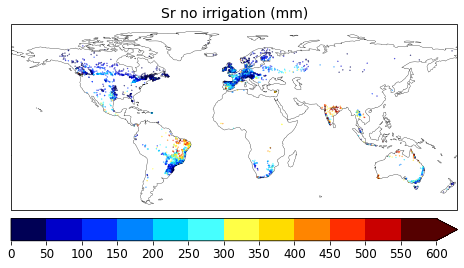

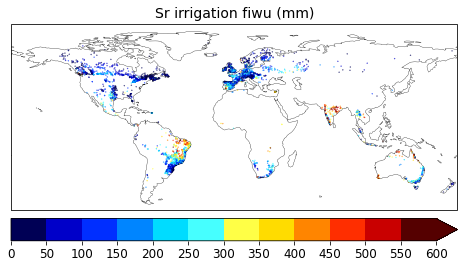

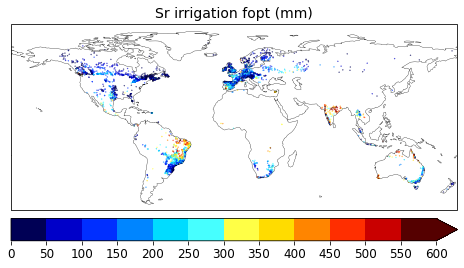

In [8]:
#shapes
sh = gpd.read_file(f'{work_dir}/output/geo_catchments_sel_area_wb.shp')
sh.index = sh.catch_id
sh['centroid'] = sh.centroid

sr_df['lat'] = sh.centroid.y
sr_df['lon'] = sh.centroid.x

bounds = np.linspace(0,600,13)
bounds2 = np.linspace(0,600,13)
norm = mpl.colors.BoundaryNorm(bounds, cm.N)

# no irrigation
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=sr_df['sr_20_f0'],s=0.1,cmap=cm, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.02, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
ax.set_title(f'Sr no irrigation (mm)',size=14)
fig.savefig(f'{work_dir}/output/figures/irrigation/sr_map_T20_no_irrigation.jpg',bbox_inches='tight',dpi=300)

# irrigation fiwu
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=sr_df['sr_20_fiwu'],s=0.1,cmap=cm, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.02, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
ax.set_title(f'Sr irrigation fiwu (mm)',size=14)
fig.savefig(f'{work_dir}/output/figures/irrigation/sr_map_T20_irrigation_fiwu.jpg',bbox_inches='tight',dpi=300)

# irrigation fopt
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=sr_df['sr_20_fopt'],s=0.1,cmap=cm, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.02, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
ax.set_title(f'Sr irrigation fopt (mm)',size=14)
fig.savefig(f'{work_dir}/output/figures/irrigation/sr_map_T20_irrigation_fopt.jpg',bbox_inches='tight',dpi=300)

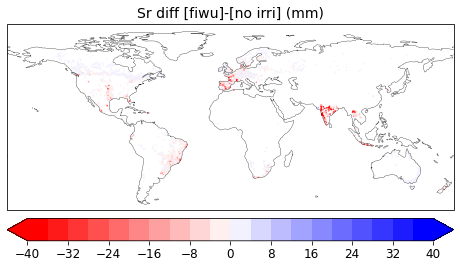

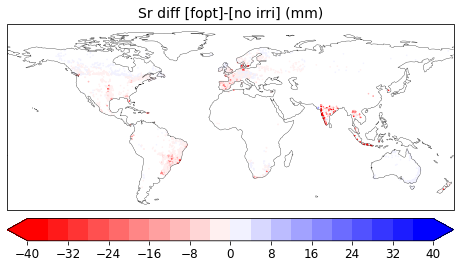

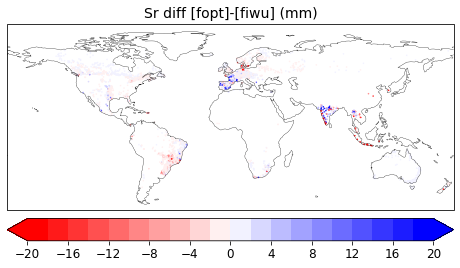

In [15]:
# ABSOLUTE DIFFERENCES IN SR
sh = gpd.read_file(f'{work_dir}/output/geo_catchments_sel_area_wb.shp')
sh.index = sh.catch_id
sh['centroid'] = sh.centroid

e_df['lat'] = sh.centroid.y
e_df['lon'] = sh.centroid.x

cm = plt.cm.bwr_r

bounds = np.linspace(-40,40,21)
bounds2 = np.linspace(-40,40,11)
norm = mpl.colors.BoundaryNorm(bounds, cm.N)

# no irrigation vs fiwu
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=e_df['f0_fiwu'],s=0.3,cmap=cm, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
ax.set_title(f'Sr diff [fiwu]-[no irri] (mm)',size=14)
fig.savefig(f'{work_dir}/output/figures/irrigation/srdiff_map_T20_no_irrigation_fiwu.jpg',bbox_inches='tight',dpi=300)

# no irrigation vs fiwu
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=e_df['f0_fopt'],s=0.3,cmap=cm, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
ax.set_title(f'Sr diff [fopt]-[no irri] (mm)',size=14)
fig.savefig(f'{work_dir}/output/figures/irrigation/srdiff_map_T20_no_irrigation_fopt.jpg',bbox_inches='tight',dpi=300)


bounds = np.linspace(-20,20,21)
bounds2 = np.linspace(-20,20,11)
norm = mpl.colors.BoundaryNorm(bounds, cm.N)

# fiwu vs fopt
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=e_df['fopt_fiwu'],s=0.3,cmap=cm, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
ax.set_title(f'Sr diff [fopt]-[fiwu] (mm)',size=14)
fig.savefig(f'{work_dir}/output/figures/irrigation/srdiff_map_T20_fopt_fiwu.jpg',bbox_inches='tight',dpi=300)

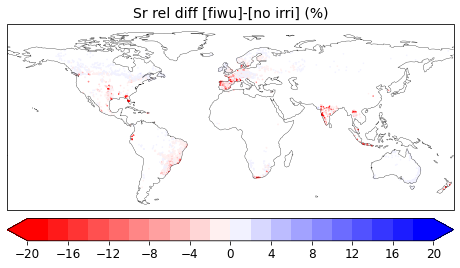

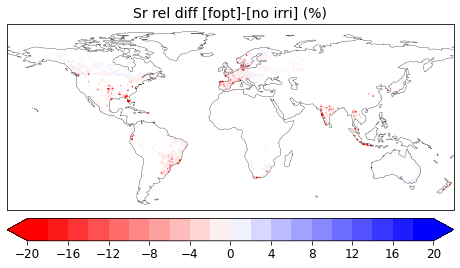

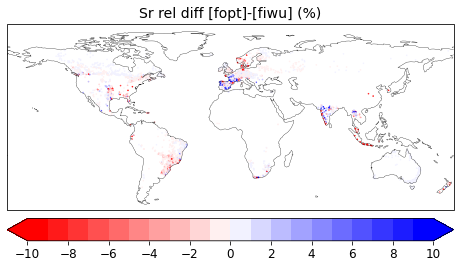

In [16]:
# RELATIVE DIFFERENCES IN SR
sh = gpd.read_file(f'{work_dir}/output/geo_catchments_sel_area_wb.shp')
sh.index = sh.catch_id
sh['centroid'] = sh.centroid

er_df['lat'] = sh.centroid.y
er_df['lon'] = sh.centroid.x

cm = plt.cm.bwr_r

bounds = np.linspace(-20,20,21)
bounds2 = np.linspace(-20,20,11)
norm = mpl.colors.BoundaryNorm(bounds, cm.N)

# no irrigation vs fiwu
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=er_df['f0_fiwu'],s=0.3,cmap=cm, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
ax.set_title(f'Sr rel diff [fiwu]-[no irri] (%)',size=14)
fig.savefig(f'{work_dir}/output/figures/irrigation/srdiff_rel_map_T20_no_irrigation_fiwu.jpg',bbox_inches='tight',dpi=300)

# no irrigation vs fiwu
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=er_df['f0_fopt'],s=0.3,cmap=cm, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
ax.set_title(f'Sr rel diff [fopt]-[no irri] (%)',size=14)
fig.savefig(f'{work_dir}/output/figures/irrigation/srdiff_rel_map_T20_no_irrigation_fopt.jpg',bbox_inches='tight',dpi=300)


bounds = np.linspace(-10,10,21)
bounds2 = np.linspace(-10,10,11)
norm = mpl.colors.BoundaryNorm(bounds, cm.N)

# fiwu vs fopt
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=er_df['fopt_fiwu'],s=0.3,cmap=cm, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
ax.set_title(f'Sr rel diff [fopt]-[fiwu] (%)',size=14)
fig.savefig(f'{work_dir}/output/figures/irrigation/srdiff_rel_map_T20_fopt_fiwu.jpg',bbox_inches='tight',dpi=300)

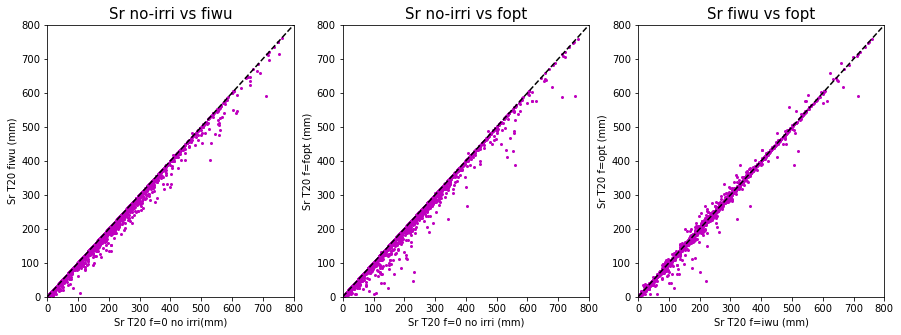

In [18]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
ax.plot(sr_df.sr_20_f0, sr_df.sr_20_fiwu, 'mo',markersize=2)
ax.plot([0,900],[0,900],'k--')
ax.set_xlabel('Sr T20 f=0 no irri(mm)')
ax.set_ylabel('Sr T20 fiwu (mm)')
# ax.annotate(f'avg abs dev={np.round(abs(sr_df.sr_20_f0-sr_df.sr_20_fiwu).mean(),0)}mm',[100,700],size=12)
ax.set_xlim(0,800)
ax.set_ylim(0,800)
ax.set_title('Sr no-irri vs fiwu',fontsize=15)

ax = fig.add_subplot(132)
ax.plot(sr_df.sr_20_f0, sr_df.sr_20_fopt, 'mo',markersize=2)
ax.plot([0,900],[0,900],'k--')
ax.set_xlabel('Sr T20 f=0 no irri (mm)')
ax.set_ylabel('Sr T20 f=fopt (mm)')
# ax.annotate(f'avg abs dev={np.round(abs(sr_df.sr_20_f0-sr_df.sr_20_fopt).mean(),0)}mm',[100,700],size=12)
ax.set_xlim(0,800)
ax.set_ylim(0,800)
ax.set_title('Sr no-irri vs fopt',fontsize=15)

ax = fig.add_subplot(133)
ax.plot(sr_df.sr_20_fiwu, sr_df.sr_20_fopt, 'mo',markersize=2)
ax.plot([0,900],[0,900],'k--')
ax.set_xlabel('Sr T20 f=iwu (mm)')
ax.set_ylabel('Sr T20 f=opt (mm)')
# ax.annotate(f'avg abs dev={np.round(abs(sr_df.sr_20_fiwu-sr_df.sr_20_fopt).mean(),0)}mm',[100,700],size=12)
ax.set_xlim(0,800)
ax.set_ylim(0,800)
ax.set_title('Sr fiwu vs fopt',fontsize=15)

fig.savefig(f'{work_dir}/output/figures/irrigation/sr_differences_f_irrigation.jpg', dpi=300, bbox_inches='tight')


,median,mean,std,iqr
f0_fiwu,-0.02,-2.72,8.18,1.40
f0_fopt,-0.27,-3.29,11.05,1.88
fopt_fiwu,-0.01,-0.57,7.96,0.51


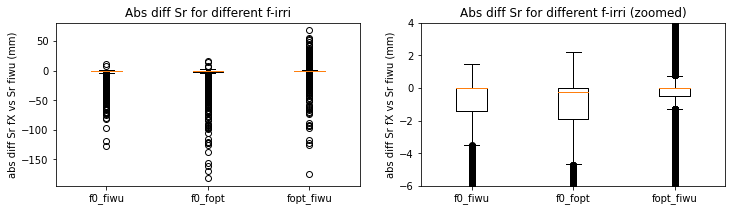

In [38]:
# boxplots of absolute errors between different Sr
e_df = pd.DataFrame(index=sr_df.index, columns=['f0_fiwu','f0_fopt','fopt_fiwu'])
e_df['f0_fiwu'] = f0_iwu_e
e_df['f0_fopt'] = f0_opt_e
e_df['fopt_fiwu'] = fopt_iwu_e

er_df = pd.DataFrame(index=sr_df.index, columns=['f0_fiwu','f0_fopt','fopt_fiwu'])
er_df['f0_fiwu'] = f0_iwu_er
er_df['f0_fopt'] = f0_opt_er
er_df['fopt_fiwu'] = fopt_iwu_er


e_df = e_df.dropna()
er_df = er_df.dropna()
e_df=e_df.iloc[:,0:3]
er_df=er_df.iloc[:,0:3]

fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(121)
ax.boxplot(e_df)
ax.set_xticklabels(e_df.columns)
ax.set_ylabel('abs diff Sr fX vs Sr fiwu (mm)')
ax.set_title('Abs diff Sr for different f-irri')

ax = fig.add_subplot(122)
ax.boxplot(e_df)
ax.set_xticklabels(e_df.columns)
ax.set_ylabel('abs diff Sr fX vs Sr fiwu (mm)')
ax.set_ylim(-6,4)
ax.set_title('Abs diff Sr for different f-irri (zoomed)')
fig.savefig(f'{work_dir}/output/figures/irrigation/boxplot_sr_diff.jpg', dpi=300, bbox_inches='tight')

d = pd.DataFrame(index=e_df.columns, columns=['median','mean','std'])
d['median']=np.round(e_df.median(),2)
d['mean']=np.round(e_df.mean(),2)
d['std']=np.round(e_df.std(),2)
d['iqr'] = np.round((e_df.quantile(0.75) - e_df.quantile(0.25)),2)

d

,median,mean,std,iqr
f0_fiwu,-0.02,-1.88,5.99,0.98
f0_fopt,-0.21,-2.59,7.81,1.47
fopt_fiwu,-0.01,-0.71,6.20,0.45


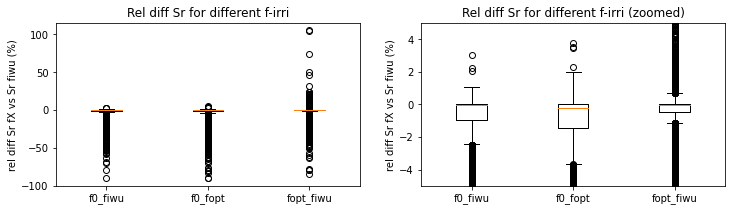

In [39]:
# boxplots of relative errors between se-mean and IWU for different fvalues
er_df = er_df.dropna()

fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(121)
ax.boxplot(er_df)
ax.set_xticklabels(e_df.columns)
ax.set_ylabel('rel diff Sr fX vs Sr fiwu (%)')
ax.set_title('Rel diff Sr for different f-irri')

ax = fig.add_subplot(122)
ax.boxplot(er_df)
ax.set_xticklabels(e_df.columns)
ax.set_ylabel('rel diff Sr fX vs Sr fiwu (%)')
ax.set_ylim(-5,5)
ax.set_title('Rel diff Sr for different f-irri (zoomed)')
fig.savefig(f'{work_dir}/output/figures/irrigation/boxplot_sr_diff_rel.jpg', dpi=300, bbox_inches='tight')

d = pd.DataFrame(index=er_df.columns, columns=['median','mean','std'])
d['median']=np.round(er_df.median(),2)
d['mean']=np.round(er_df.mean(),2)
d['std']=np.round(er_df.std(),2)
d['iqr'] = np.round((er_df.quantile(0.75) - er_df.quantile(0.25)),2)

d

,median,mean,std,iqr
f0_fiwu,-21.71,-25.88,22.26,24.78
f0_fopt,-24.64,-35.02,36.55,34.57
fopt_fiwu,-0.36,-9.14,31.90,21.47


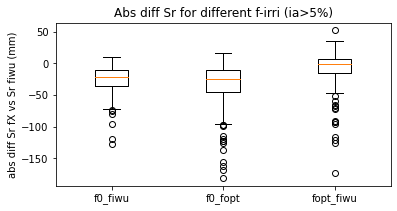

In [40]:
# boxplots of absolute errors between different Sr - for irri catchments with IA>5%
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
ir = df.ir_mean

e_df = e_df.dropna()
er_df = er_df.dropna()
e_df=e_df.iloc[:,0:3]
er_df=er_df.iloc[:,0:3]

e_df = e_df[ir>0.05] #select catchments with more than x% irrigation area fraction 
er_df = er_df[ir>0.05] #select catchments with more than x% irrigation area fraction 

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)
ax.boxplot(e_df)
ax.set_xticklabels(e_df.columns)
ax.set_ylabel('abs diff Sr fX vs Sr fiwu (mm)')
ax.set_title('Abs diff Sr for different f-irri (ia>5%)')
fig.savefig(f'{work_dir}/output/figures/irrigation/boxplot_sr_diff_ia5.jpg', dpi=300, bbox_inches='tight')

d = pd.DataFrame(index=e_df.columns, columns=['median','mean','std'])
d['median']=np.round(e_df.median(),2)
d['mean']=np.round(e_df.mean(),2)
d['std']=np.round(e_df.std(),2)
d['iqr'] = np.round((e_df.quantile(0.75) - e_df.quantile(0.25)),2)

d

,median,mean,std,iqr
f0_fiwu,-10.03,-14.09,14.05,14.33
f0_fopt,-13.43,-20.03,20.50,27.60
fopt_fiwu,-0.37,-6.89,18.36,15.08


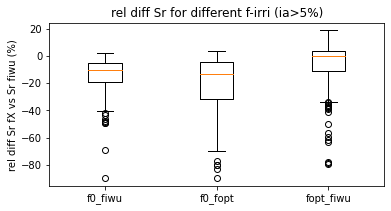

In [41]:
# relative errors ia>5%
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)
ax.boxplot(er_df)
ax.set_xticklabels(e_df.columns)
ax.set_ylabel('rel diff Sr fX vs Sr fiwu (%)')
ax.set_title('rel diff Sr for different f-irri (ia>5%)')
fig.savefig(f'{work_dir}/output/figures/irrigation/boxplot_sr_diff_rel_ia5.jpg', dpi=300, bbox_inches='tight')

d = pd.DataFrame(index=er_df.columns, columns=['median','mean','std'])
d['median']=np.round(er_df.median(),2)
d['mean']=np.round(er_df.mean(),2)
d['std']=np.round(er_df.std(),2)
d['iqr'] = np.round((er_df.quantile(0.75) - er_df.quantile(0.25)),2)

d

In [152]:
# # plot f values for fiwu vs f0.17
# f = 'iwu'
# fm = []
# for catch_id in el_id_list:
#     if os.path.exists(f'{ifol}/se/{catch_id}_f{f}.csv'):
#         d = pd.read_csv(f'{ifol}/se/{catch_id}_f{f}.csv',index_col=0)
#         fmean = d['f'].mean()
#         fm.append(fmean)
        
# fmia = []
# for catch_id in el_id_list:
#     if os.path.exists(f'{ifol}/se/{catch_id}_f2.0ia.csv'):
#         d = pd.read_csv(f'{ifol}/se/{catch_id}_f2.0ia.csv',index_col=0)
#         fmean = d['f'].mean()
#         fmia.append(fmean)

In [20]:
# plot f values for fiwu vs f1.9ia
f = 'iwu'
fm = []
for catch_id in el_id_list:
    if os.path.exists(f'{ifol}/se/{catch_id}_f{f}.csv'):
        d = pd.read_csv(f'{ifol}/se/{catch_id}_f{f}.csv',index_col=0)
        fmean = d['f'].mean()
        fm.append(fmean)
        
fmia = []
for catch_id in el_id_list:
    if os.path.exists(f'{ifol}/se/{catch_id}_f1.9ia.csv'):
        d = pd.read_csv(f'{ifol}/se/{catch_id}_f1.9ia.csv',index_col=0)
        fmean = d['f'].mean()
        fmia.append(fmean)

Text(0.5, 1.0, 'mean f with fiwu vs f=2.0ia')

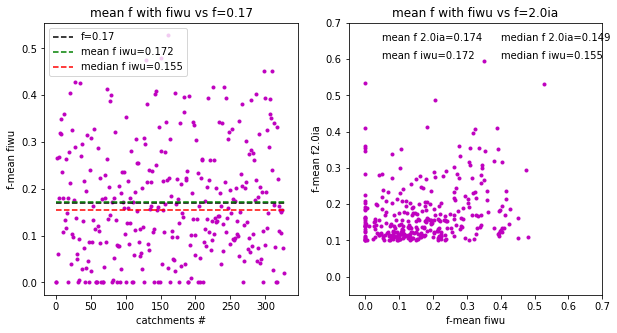

In [153]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.plot(fm, 'mo',markersize=3)
ax.plot([0,330],[0.17,0.17],'k--', label=f'f=0.17')
ax.plot([0,330],[np.mean(fm),np.mean(fm)],'g--', label=f'mean f iwu={np.round(np.mean(fm),3)}')
ax.plot([0,330],[np.median(fm),np.median(fm)],'r--', label=f'median f iwu={np.round(np.median(fm),3)}')
ax.legend()
ax.set_xlabel('catchments #')
ax.set_ylabel('f-mean fiwu')
ax.set_title('mean f with fiwu vs f=0.17')

ax = fig.add_subplot(122)
ax.plot(fm,fmia, 'mo',markersize=3)
ax.annotate(f'mean f iwu={np.round(np.mean(fm),3)}',[0.05,0.6])
ax.annotate(f'mean f 2.0ia={np.round(np.mean(fmia),3)}',[0.05,0.65])
ax.annotate(f'median f iwu={np.round(np.median(fm),3)}',[0.40,0.6])
ax.annotate(f'median f 2.0ia={np.round(np.median(fmia),3)}',[0.40,0.65])
ax.set_xlabel('f-mean fiwu')
ax.set_ylabel('f-mean f2.0ia')
ax.set_xlim(-0.05,0.7)
ax.set_ylim(-0.05,0.7)
ax.set_title('mean f with fiwu vs f=2.0ia')


## 3. OPTIMIZE F WITHOUT IRRIGATION AREA FRACTION

In [29]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
ir = df.ir_mean
ir = ir[ir>0.05]
ar = df.area

In [30]:
# check which catchments are missing
catch_list = np.genfromtxt(f'{work_dir}/output/irrigation/catchment_irri_area_5percent.txt',dtype='str')[:]
el_id_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/sd/*0.18.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-10] # remove .year extension
    el_id_list.append(f)
dif = list(set(catch_list) - set(el_id_list))
len(dif)

18

In [31]:
md_05 = []
md_025 = []
md_075 = []
md_015 = []
md_0 = []
md_02 = []
md_018 = []
md_017 = []
md_iwu = []

md_02_rel = []
md_05_rel = []
md_025_rel = []
md_075_rel = []
md_015_rel = []
md_0_rel = []
md_018_rel = []
md_017_rel = []
md_iwu_rel = []

iwu=[]

ifol = f'{work_dir}/output/sr_calculation/sd_catchments/irri/'

for catch_id in el_id_list:
    f=0.5
    d = pd.read_csv(f'{ifol}/se/{catch_id}_f{f}.csv',index_col=0)
    md_05.append(d.se_used.mean() - d.iwu_mean.mean())
    if (d.iwu_mean.mean()>0):
        md_05_rel.append(((d.se_used.mean() - d.iwu_mean.mean())/d.iwu_mean.mean())*100)
    else:
        md_05_rel.append(np.nan)
    
    f=0
    d = pd.read_csv(f'{ifol}/se/{catch_id}_f{f}.csv',index_col=0)
    md_0.append(d.se_used.mean() - d.iwu_mean.mean())
    if (d.iwu_mean.mean()>0):
        md_0_rel.append(((d.se_used.mean() - d.iwu_mean.mean())/d.iwu_mean.mean())*100)
    else:
        md_0_rel.append(np.nan)
    
    f=0.25
    d = pd.read_csv(f'{ifol}/se/{catch_id}_f{f}.csv',index_col=0)
    md_025.append(d.se_used.mean() - d.iwu_mean.mean())
    if (d.iwu_mean.mean()>0):
        md_025_rel.append(((d.se_used.mean() - d.iwu_mean.mean())/d.iwu_mean.mean())*100)
    else:
        md_025_rel.append(np.nan)
        
    f=0.2
    d = pd.read_csv(f'{ifol}/se/{catch_id}_f{f}.csv',index_col=0)
    md_02.append(d.se_used.mean() - d.iwu_mean.mean())
    if (d.iwu_mean.mean()>0):
        md_02_rel.append(((d.se_used.mean() - d.iwu_mean.mean())/d.iwu_mean.mean())*100)
    else:
        md_02_rel.append(np.nan)
    
    f=0.15
    d = pd.read_csv(f'{ifol}/se/{catch_id}_f{f}.csv',index_col=0)
    md_015.append(d.se_used.mean() - d.iwu_mean.mean())
    if (d.iwu_mean.mean()>0):
        md_015_rel.append(((d.se_used.mean() - d.iwu_mean.mean())/d.iwu_mean.mean())*100)
    else:
        md_015_rel.append(np.nan)
    
    f=0.18
    d = pd.read_csv(f'{ifol}/se/{catch_id}_f{f}.csv',index_col=0)
    md_018.append(d.se_used.mean() - d.iwu_mean.mean())
    if (d.iwu_mean.mean()>0):
        md_018_rel.append(((d.se_used.mean() - d.iwu_mean.mean())/d.iwu_mean.mean())*100)
    else:
        md_018_rel.append(np.nan)
        
    f=0.17
    d = pd.read_csv(f'{ifol}/se/{catch_id}_f{f}.csv',index_col=0)
    md_017.append(d.se_used.mean() - d.iwu_mean.mean())
    if (d.iwu_mean.mean()>0):
        md_017_rel.append(((d.se_used.mean() - d.iwu_mean.mean())/d.iwu_mean.mean())*100)
    else:
        md_017_rel.append(np.nan)
        
    f='iwu'
    d = pd.read_csv(f'{ifol}/se/{catch_id}_f{f}.csv',index_col=0)
    md_iwu.append(d.se_used.mean() - d.iwu_mean.mean())
    if (d.iwu_mean.mean()>0):
        md_iwu_rel.append(((d.se_used.mean() - d.iwu_mean.mean())/d.iwu_mean.mean())*100)
    else:
        md_iwu_rel.append(np.nan)
        
    iwu.append(d.iwu_mean.mean())

In [32]:
df = pd.DataFrame(index=el_id_list[:], columns=['iwu','f0','f0.15','f0.17','f0.18','f0.2','f0.25','f0.5','fiwu'])
df['f0'] = md_0
df['f0.15'] = md_015
df['f0.17'] = md_017
df['f0.18'] = md_018
df['f0.2'] = md_02
df['f0.25'] = md_025
df['f0.5'] = md_05
df['fiwu'] = md_iwu
df['iwu'] = iwu
df = df.dropna()

dfr = pd.DataFrame(index=el_id_list[:], columns=['iwu','f0','f0.15','f0.17','f0.18','f0.2','f0.25','f0.5','fiwu'])
dfr['f0'] = md_0_rel
dfr['f0.15'] = md_015_rel
dfr['f0.17'] = md_017_rel
dfr['f0.18'] = md_018_rel
dfr['f0.2'] = md_02_rel
dfr['f0.25'] = md_025_rel
dfr['f0.5'] = md_05_rel
dfr['fiwu'] = md_iwu_rel
dfr['iwu'] = iwu
dfr = dfr.dropna()

df['irri_areaf'] = ir
dfr['irri_areaf'] = ir
df['irri_area'] = ir*ar
dfr['irri_area'] = ir*ar

dff = df
dffr = dfr

,median,mean,std,q75-q25
f0,-42.41,-47.54,27.26,33.12
f0.15,-6.96,4.47,64.15,49.38
f0.17,-0.38,12.59,72.38,56.59
f0.18,1.27,16.75,76.69,59.81
f0.2,6.76,25.32,85.49,66.20
f0.25,26.01,48.20,109.12,82.49
f0.5,150.12,198.79,259.96,212.56
fiwu,-2.91,-11.16,18.44,13.67


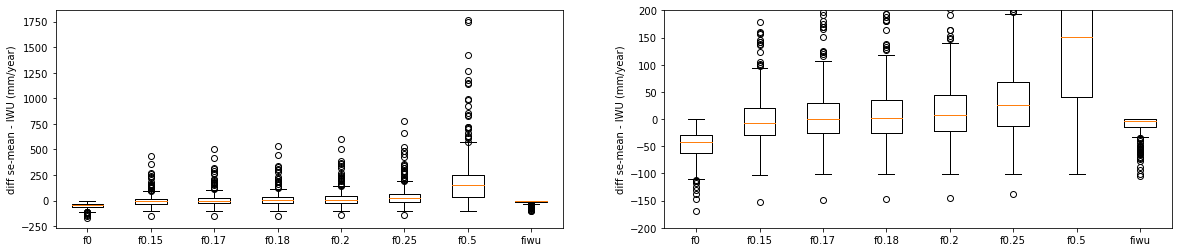

In [33]:
# boxplots of absolute errors between se-mean and IWU for different fvalues
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(121)
ax.boxplot(dff.iloc[:,1:-2])
ax.set_xticklabels(dff.iloc[:,1:-2].columns)
ax.set_ylabel('diff se-mean - IWU (mm/year)')

ax = fig.add_subplot(122)
ax.boxplot(dff.iloc[:,1:-2])
ax.set_xticklabels(dff.iloc[:,1:-2].columns)
ax.set_ylim(-200,200)
ax.set_ylabel('diff se-mean - IWU (mm/year)')

d = pd.DataFrame(index=dff.iloc[:,1:-2].columns, columns=['median','mean','std','q75-q25'])
d['median']=np.round(dff.iloc[:,1:-2].median(),2)
d['mean']=np.round(dff.iloc[:,1:-2].mean(),2)
d['std']=np.round(dff.iloc[:,1:-2].std(),2)
d['q75-q25'] = np.round((dff.iloc[:,1:-2].quantile(0.75) - dff.iloc[:,1:-2].quantile(0.25)),2)
d

,median,mean,std,q75-q25
f0,-100.00,-100.00,0.00,0.00
f0.15,-17.01,220.31,2930.62,140.66
f0.17,-4.22,270.07,3384.93,162.29
f0.18,3.11,295.48,3617.72,172.88
f0.2,16.54,348.03,4098.24,196.04
f0.25,55.61,484.53,5323.05,256.97
f0.5,317.73,1321.73,12268.33,631.33
fiwu,-7.14,-23.74,31.61,35.27


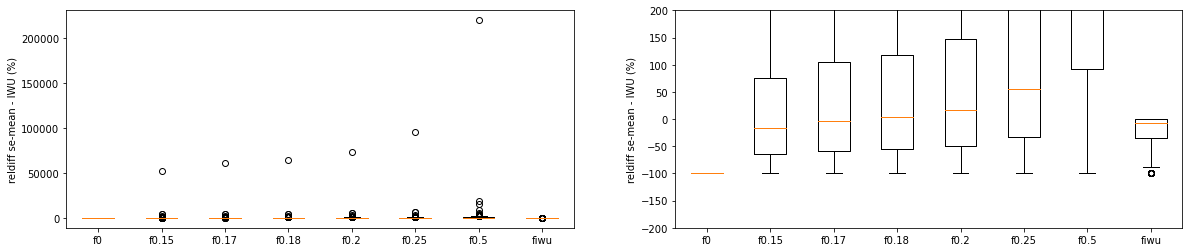

In [34]:
# boxplots of relative errors between se-mean and IWU for different fvalues
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(121)
ax.boxplot(dffr.iloc[:,1:-2])
ax.set_xticklabels(dffr.iloc[:,1:-2].columns)
ax.set_ylabel('reldiff se-mean - IWU (%)')

ax = fig.add_subplot(122)
ax.boxplot(dffr.iloc[:,1:-2])
ax.set_xticklabels(dffr.iloc[:,1:-2].columns)
ax.set_ylim(-200,200)
ax.set_ylabel('reldiff se-mean - IWU (%)')

d = pd.DataFrame(index=dffr.iloc[:,1:-2].columns, columns=['median','mean','std','q75-q25'])
d['median']=np.round(dffr.iloc[:,1:-2].median(),2)
d['mean']=np.round(dffr.iloc[:,1:-2].mean(),2)
d['std']=np.round(dffr.iloc[:,1:-2].std(),2)
d['q75-q25'] = np.round((dffr.iloc[:,1:-2].quantile(0.75) - dffr.iloc[:,1:-2].quantile(0.25)),2)
d

## 4. IRRIGATION AREA FRACTION  * F - optimize f

In [35]:
# check which catchments are missing
catch_list = np.genfromtxt(f'{work_dir}/output/irrigation/catchment_irri_area_5percent.txt',dtype='str')[:]
el_id_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/sd/*2.2ia.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-11] # remove .year extension
    el_id_list.append(f)
dif = list(set(catch_list) - set(el_id_list))
len(dif)

18

In [36]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
ir = df.ir_mean
ir = ir[ir>0.05]
ar = df.area

In [37]:
md_18 = []
md_12 = []
md_0 = []
md_08 = []
md_1 = []
md_15 = []
md_2 = []
md_25 = []
md_22 = []
md_3 = []
md_iwu = []

md_08_rel = []
md_18_rel = []
md_12_rel = []
md_0_rel = []
md_1_rel = []
md_15_rel = []
md_2_rel = []
md_25_rel = []
md_22_rel = []
md_3_rel = []
md_iwu_rel = []

iwu=[]

ifol = f'{work_dir}/output/sr_calculation/sd_catchments/irri/'

for catch_id in el_id_list:
#     f=0.5
#     d = pd.read_csv(f'{ifol}/se/{catch_id}_f{f}ia.csv',index_col=0)
#     md_05.append(d.se_used.mean() - d.iwu_mean.mean())
#     if (d.iwu_mean.mean()>0):
#         md_05_rel.append(((d.se_used.mean() - d.iwu_mean.mean())/d.iwu_mean.mean())*100)
#     else:
#         md_05_rel.append(np.nan)
    
    f=1.8
    d = pd.read_csv(f'{ifol}/se/{catch_id}_f{f}ia.csv',index_col=0)
    md_18.append(d.se_used.mean() - d.iwu_mean.mean())
    if (d.iwu_mean.mean()>0):
        md_18_rel.append(((d.se_used.mean() - d.iwu_mean.mean())/d.iwu_mean.mean())*100)
    else:
        md_18_rel.append(np.nan)
    
    f=1.0
    d = pd.read_csv(f'{ifol}/se/{catch_id}_f{f}ia.csv',index_col=0)
    md_1.append(d.se_used.mean() - d.iwu_mean.mean())
    if (d.iwu_mean.mean()>0):
        md_1_rel.append(((d.se_used.mean() - d.iwu_mean.mean())/d.iwu_mean.mean())*100)
    else:
        md_1_rel.append(np.nan)
    
    # f=1.2
    # d = pd.read_csv(f'{ifol}/se/{catch_id}_f{f}ia.csv',index_col=0)
    # md_12.append(d.se_used.mean() - d.iwu_mean.mean())
    # if (d.iwu_mean.mean()>0):
    #     md_12_rel.append(((d.se_used.mean() - d.iwu_mean.mean())/d.iwu_mean.mean())*100)
    # else:
    #     md_12_rel.append(np.nan)
        
    f=1.5
    d = pd.read_csv(f'{ifol}/se/{catch_id}_f{f}ia.csv',index_col=0)
    md_15.append(d.se_used.mean() - d.iwu_mean.mean())
    if (d.iwu_mean.mean()>0):
        md_15_rel.append(((d.se_used.mean() - d.iwu_mean.mean())/d.iwu_mean.mean())*100)
    else:
        md_15_rel.append(np.nan)
        
    f=2.0
    d = pd.read_csv(f'{ifol}/se/{catch_id}_f{f}ia.csv',index_col=0)
    md_2.append(d.se_used.mean() - d.iwu_mean.mean())
    if (d.iwu_mean.mean()>0):
        md_2_rel.append(((d.se_used.mean() - d.iwu_mean.mean())/d.iwu_mean.mean())*100)
    else:
        md_2_rel.append(np.nan)
        
    f=2.2
    d = pd.read_csv(f'{ifol}/se/{catch_id}_f{f}ia.csv',index_col=0)
    md_22.append(d.se_used.mean() - d.iwu_mean.mean())
    if (d.iwu_mean.mean()>0):
        md_22_rel.append(((d.se_used.mean() - d.iwu_mean.mean())/d.iwu_mean.mean())*100)
    else:
        md_22_rel.append(np.nan)
        
    f=2.5
    d = pd.read_csv(f'{ifol}/se/{catch_id}_f{f}ia.csv',index_col=0)
    md_25.append(d.se_used.mean() - d.iwu_mean.mean())
    if (d.iwu_mean.mean()>0):
        md_25_rel.append(((d.se_used.mean() - d.iwu_mean.mean())/d.iwu_mean.mean())*100)
    else:
        md_25_rel.append(np.nan)
    
    f=3.0
    d = pd.read_csv(f'{ifol}/se/{catch_id}_f{f}ia.csv',index_col=0)
    md_3.append(d.se_used.mean() - d.iwu_mean.mean())
    if (d.iwu_mean.mean()>0):
        md_3_rel.append(((d.se_used.mean() - d.iwu_mean.mean())/d.iwu_mean.mean())*100)
    else:
        md_3_rel.append(np.nan)
    
    f=0
    d = pd.read_csv(f'{ifol}/se/{catch_id}_f{f}.csv',index_col=0)
    md_0.append(d.se_used.mean() - d.iwu_mean.mean())
    if (d.iwu_mean.mean()>0):
        md_0_rel.append(((d.se_used.mean() - d.iwu_mean.mean())/d.iwu_mean.mean())*100)
    else:
        md_0_rel.append(np.nan)
        
    f='iwu'
    d = pd.read_csv(f'{ifol}/se/{catch_id}_f{f}.csv',index_col=0)
    md_iwu.append(d.se_used.mean() - d.iwu_mean.mean())
    if (d.iwu_mean.mean()>0):
        md_iwu_rel.append(((d.se_used.mean() - d.iwu_mean.mean())/d.iwu_mean.mean())*100)
    else:
        md_iwu_rel.append(np.nan)
        
    iwu.append(d.iwu_mean.mean())

In [38]:
df = pd.DataFrame(index=el_id_list[:], columns=['iwu','f0','f1.0ia','f1.5ia','f1.8ia','f2.0ia','f2.2ia','f2.5ia','f3.0ia','fiwu'])
df['f0'] = md_0
df['f1.0ia'] = md_1
df['f1.8ia'] = md_18
df['f1.5ia'] = md_15
df['f2.0ia'] = md_2
df['f2.2ia'] = md_22
df['f2.5ia'] = md_25
df['f3.0ia'] = md_3
df['fiwu'] = md_iwu

dfr = pd.DataFrame(index=el_id_list[:], columns=['iwu','f0','f1.0ia','f1.5ia','f1.8ia','f2.0ia','f2.2ia','f2.5ia','f3.0ia','fiwu'])
dfr['f0'] = md_0_rel
dfr['f1.0ia'] = md_1_rel
dfr['f1.8ia'] = md_18_rel
dfr['f1.5ia'] = md_15_rel
dfr['f2.0ia'] = md_2_rel
dfr['f2.2ia'] = md_22_rel
dfr['f2.5ia'] = md_25_rel
dfr['f3.0ia'] = md_3_rel
dfr['fiwu'] = md_iwu_rel

df['irri_areaf'] = ir
dfr['irri_areaf'] = ir
df['irri_area'] = ir*ar
dfr['irri_area'] = ir*ar

dfia = df
dfria = dfr


,median,mean,std,q75-q25
f0,-42.41,-47.54,27.26,33.12
f1.0ia,-22.21,-18.96,38.95,31.56
f1.5ia,-12.81,-2.41,54.85,38.07
f1.8ia,-5.04,8.30,66.12,47.23
f2.0ia,-0.02,15.79,74.25,55.16
f2.2ia,4.64,23.63,82.86,63.04
f2.5ia,10.70,35.89,96.62,76.07
f3.0ia,23.56,57.78,121.50,103.26
fiwu,-2.91,-11.16,18.44,13.67


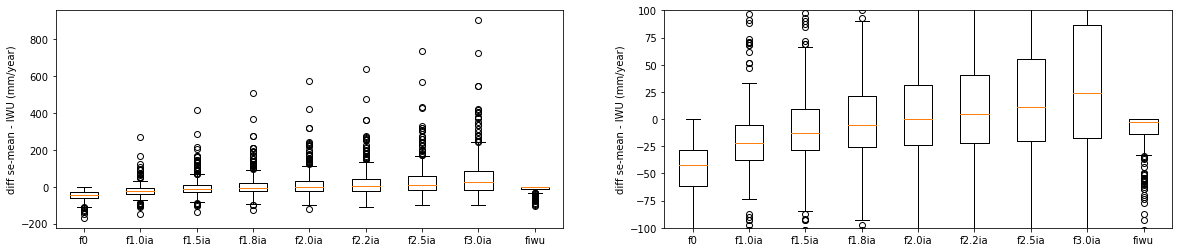

In [39]:
# boxplots of absolute errors between se-mean and IWU for different fvalues
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(121)
ax.boxplot(dfia.iloc[:,1:-2])
ax.set_xticklabels(dfia.iloc[:,1:-2].columns)
ax.set_ylabel('diff se-mean - IWU (mm/year)')

ax = fig.add_subplot(122)
ax.boxplot(dfia.iloc[:,1:-2])
ax.set_xticklabels(dfia.iloc[:,1:-2].columns)
ax.set_ylim(-100,100)
ax.set_ylabel('diff se-mean - IWU (mm/year)')

d = pd.DataFrame(index=dfia.iloc[:,1:-2].columns, columns=['median','mean','std'])
d['median']=np.round(dfia.iloc[:,1:-2].median(),2)
d['mean']=np.round(dfia.iloc[:,1:-2].mean(),2)
d['std']=np.round(dfia.iloc[:,1:-2].std(),2)
d['q75-q25'] = np.round((dfia.iloc[:,1:-2].quantile(0.75) - dfia.iloc[:,1:-2].quantile(0.25)),2)

d

,median,mean,std,q75-q25
f0,-100.00,-100.00,0.00,0.00
f1.0ia,-54.15,51.60,1319.61,65.28
f1.5ia,-28.38,136.17,2044.08,101.63
f1.8ia,-12.02,190.10,2503.11,123.60
f2.0ia,-0.10,226.92,2810.16,140.32
f2.2ia,11.84,265.27,3131.36,157.98
f2.5ia,30.10,324.70,3626.91,186.12
f3.0ia,63.05,429.70,4495.53,236.02
fiwu,-7.14,-23.74,31.61,35.27


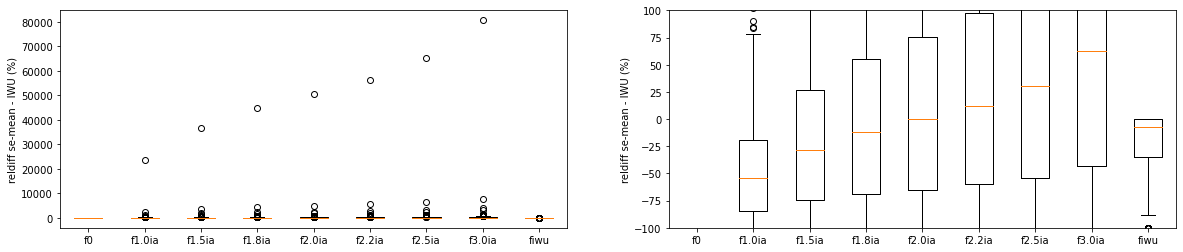

In [40]:
# boxplots of relative errors between se-mean and IWU for different fvalues
dfr2 = dfria.iloc[:,1:-2].dropna()

fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(121)
ax.boxplot(dfr2)
ax.set_xticklabels(dfr2)
ax.set_ylabel('reldiff se-mean - IWU (%)')

ax = fig.add_subplot(122)
ax.boxplot(dfr2)
ax.set_xticklabels(dfr2)
ax.set_ylim(-100,100)
ax.set_ylabel('reldiff se-mean - IWU (%)')

d = pd.DataFrame(index=dfria.iloc[:,1:-2].columns, columns=['median','mean','std'])
d['median']=np.round(dfria.iloc[:,1:-2].median(),2)
d['mean']=np.round(dfria.iloc[:,1:-2].mean(),2)
d['std']=np.round(dfria.iloc[:,1:-2].std(),2)
d['q75-q25'] = np.round((dfria.iloc[:,1:-2].quantile(0.75) - dfria.iloc[:,1:-2].quantile(0.25)),2)

d

## 5. COMBINE IRRI OPTIMIZED F WITH AND WITHOUT IRRI AREA FRACTION


In [51]:
df = pd.concat([dff,dfia],axis=1)
dfr = pd.concat([dffr, dfria],axis=1)

dfs = df[['f0','fiwu','f0.17','f0.18','f1.8ia','f2.0ia','f2.2ia']]
dfrs = dfr[['f0','fiwu','f0.17','f0.18','f1.8ia','f2.0ia','f2.2ia']]

dfs = dfs.loc[:,~dfs.columns.duplicated()].copy()
dfrs = dfrs.loc[:,~dfrs.columns.duplicated()].copy()

,median,mean,std,q75-q25
f0,-42.41,-47.54,27.26,33.12
fiwu,-2.91,-11.16,18.44,13.67
f0.17,-0.38,12.59,72.38,56.59
f0.18,1.27,16.75,76.69,59.81
f1.8ia,-5.04,8.30,66.12,47.23
f2.0ia,-0.02,15.79,74.25,55.16
f2.2ia,4.64,23.63,82.86,63.04


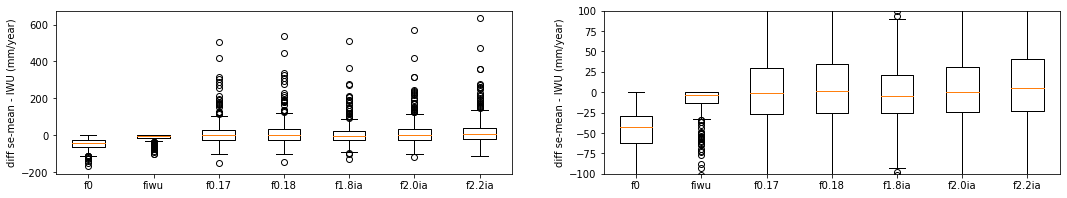

In [60]:
# boxplots of absolute errors between se-mean and IWU for different fvalues
fig = plt.figure(figsize=(18,3))
ax = fig.add_subplot(121)
ax.boxplot(dfs)
ax.set_xticklabels(dfs.columns)
ax.set_ylabel('diff se-mean - IWU (mm/year)')

ax = fig.add_subplot(122)
ax.boxplot(dfs)
ax.set_xticklabels(dfs.columns)
ax.set_ylim(-100,100)
ax.set_ylabel('diff se-mean - IWU (mm/year)')
fig.savefig(f'{work_dir}/output/figures/irrigation/boxplot_abs_errors_iwu.jpg', dpi=300, bbox_inches='tight')

d = pd.DataFrame(index=dfs.columns, columns=['median','mean','std'])
d['median']=np.round(dfs.median(),2)
d['mean']=np.round(dfs.mean(),2)
d['std']=np.round(dfs.std(),2)
d['q75-q25'] = np.round((dfs.quantile(0.75) - dfs.quantile(0.25)),2)

d

,median,mean,std,q75-q25
f0,-100.00,-100.00,0.00,0.00
fiwu,-7.14,-23.74,31.61,35.27
f0.17,-4.22,270.07,3384.93,162.29
f0.18,3.11,295.48,3617.72,172.88
f1.8ia,-12.02,190.10,2503.11,123.60
f2.0ia,-0.10,226.92,2810.16,140.32
f2.2ia,11.84,265.27,3131.36,157.98


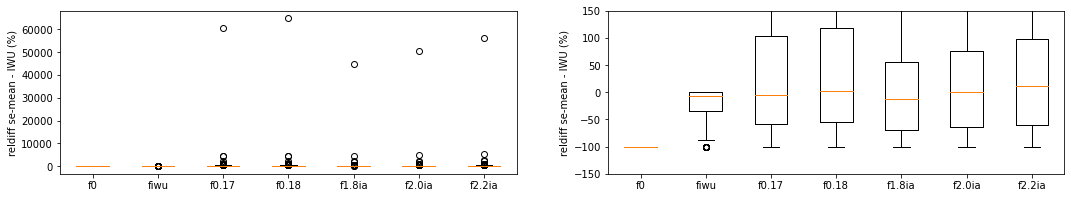

In [61]:
# boxplots of absolute errors between se-mean and IWU for different fvalues
dfrs = dfrs.dropna()

fig = plt.figure(figsize=(18,3))
ax = fig.add_subplot(121)
ax.boxplot(dfrs)
ax.set_xticklabels(dfrs.columns)
ax.set_ylabel('reldiff se-mean - IWU (%)')

ax = fig.add_subplot(122)
ax.boxplot(dfrs)
ax.set_xticklabels(dfrs.columns)
ax.set_ylim(-150,150)
ax.set_ylabel('reldiff se-mean - IWU (%)')
fig.savefig(f'{work_dir}/output/figures/irrigation/boxplot_rel_errors_iwu.jpg', dpi=300, bbox_inches='tight')

d = pd.DataFrame(index=dfrs.columns, columns=['median','mean','std'])
d['median']=np.round(dfrs.median(),2)
d['mean']=np.round(dfrs.mean(),2)
d['std']=np.round(dfrs.std(),2)
d['q75-q25'] = np.round((dfrs.quantile(0.75) - dfrs.quantile(0.25)),2)

d

Text(0.5, 1.0, 'mean f with fiwu vs f=2.0ia')

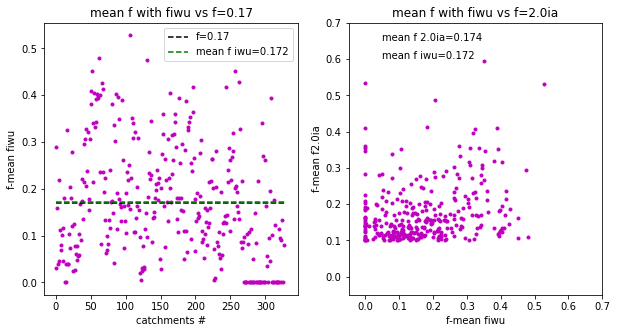

### f optimization

,median,mean,std,iqr,rmse
0.0,-0.155,-0.172,0.121,0.176,0.210
1.0,-0.076,-0.084,0.118,0.156,0.145
1.5,-0.032,-0.041,0.121,0.151,0.128
1.8,-0.012,-0.015,0.125,0.153,0.126
2.0,0.005,0.003,0.128,0.152,0.128
2.2,0.022,0.020,0.131,0.148,0.133
2.5,0.042,0.046,0.137,0.154,0.144
3.0,0.081,0.090,0.148,0.165,0.173


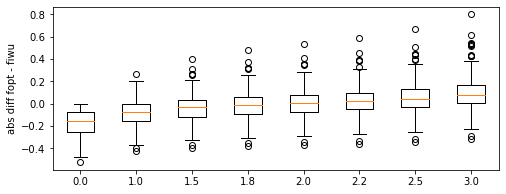

In [195]:
# boxplots
f_array=[0,1,1.5,1.8,2,2.2,2.5,3]
df = pd.DataFrame(index=d.index, columns=f_array)

for f in f_array:
    o = f*d['ia']
    er = o-d['fiwu']
    df[f] = er
    
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.boxplot(df)
ax.set_xticklabels(df.columns)
ax.set_ylabel('abs diff fopt - fiwu')

e = pd.DataFrame(index=df.columns)
e['median']=np.round(df.median(),3)
e['mean']=np.round(df.mean(),3)
e['std']=np.round(df.std(),3)
e['iqr'] = np.round((df.quantile(0.75) - df.quantile(0.25)),3)
e['rmse'] = np.round(np.sqrt(np.mean((df**2))),3)

e